In [1]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

In [2]:
# trick derived from https://stackoverflow.com/a/57832026
def display_dfs(dfs):
    """
    Display tables side by side
    
    Input:
        dfs: List of pandas.DataFrame

    Output:
        None
    """
    output = ""
    for df in dfs:
        output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
        output += 10*"\xa0"
    display(HTML(output))

# Multi-armed bandit
- Michal Kubišta
- https://github.com/kubistmi/contextual_MAB


<img src="https://diydilettante.files.wordpress.com/2011/07/the-office-pictures.jpg">

###### credits: Murder (The Office)

## Multi-armed bandit

<img src="https://slivkins.com/work/bandits-svc/MAB-2.jpg">

###### credits: Alex Slivkins - Microsoft Research Silicon Valley

# Table of contents:
1. Multi-armed bandit introduction
2. Data review
3. Code review
4. Model results

## What is MAB?

- simplified reinforcement learning problem
- set of actions that yield unknown rewards
- maximise the total reward
- exploration-exploitation tradeoff
    - based on policy

<img src="drawio/bandit.png">

## Contextual MAB

- get some context before deciding on the action

- now we can try to collect data and try to predict the reward
    - reward ~ context
- each action gets its oracle (ML model)

<img src="drawio/context.png">

### Oracle and policy

<img src="drawio/oracle_policy.png">

### And the data provider

<img src="drawio/provider.png">

# Data review

In [3]:
# dataset from https://www.kaggle.com/blastchar/telco-customer-churn
churn = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn.rename(str.lower, axis = 'columns', inplace = True)

churn.head(5)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
display(churn.value_counts('totalcharges').head(5))

churn.totalcharges = pd.to_numeric(churn.totalcharges.str.replace(" ",""))
churn.seniorcitizen = np.where(churn.seniorcitizen == 0, "no", "yes")

totalcharges
         11
20.2     11
19.75     9
20.05     8
19.9      8
dtype: int64

## Numerical variables

,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


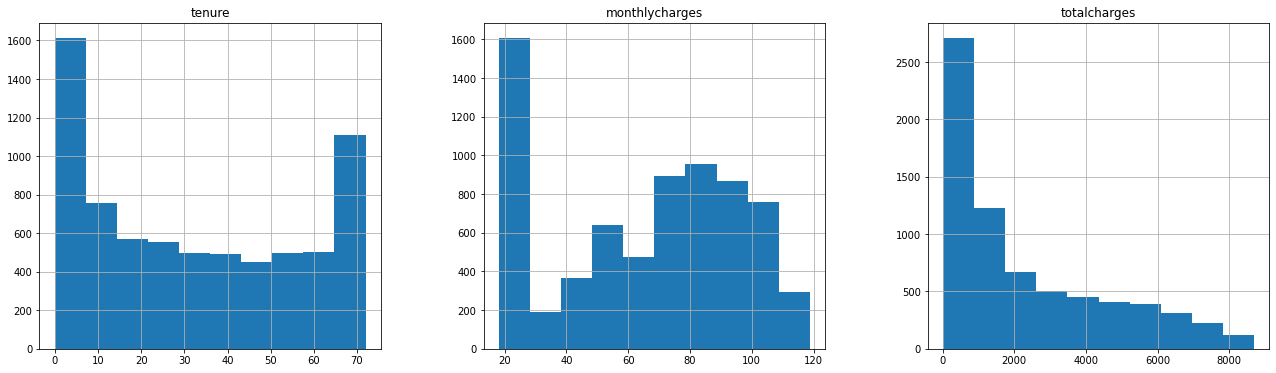

In [5]:
churn.hist(figsize = (30,6), layout = (1,4))

churn.describe()

In [6]:
cols_cat = (
    churn
    .dtypes
    .where(churn.dtypes == "object")
    .dropna()
    .index
    )

cats = [churn[i].value_counts().to_frame() for i in cols_cat if i != "customerid"]

## Categorical variables

In [7]:
display_dfs(cats)

,gender
Male,3555
Female,3488
,seniorcitizen
no,5901
yes,1142
,partner
No,3641
Yes,3402
,dependents
No,4933


## NA handling

In [8]:
(
    churn
    .isna()
    .apply(sum)
    .sort_values(ascending = False)
    .head(2)
)

totalcharges    11
customerid       0
dtype: int64

In [9]:
churn.loc[churn.totalcharges.isna()]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,4472-LVYGI,Female,no,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,no,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,no,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,no,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,no,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,no,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,no,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,no,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,no,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,no,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


## Check the hypothesis

In [10]:
lm = smf.ols("totalcharges ~ monthlycharges:tenure", churn).fit()
summary = lm.summary()
summary.extra_txt = ''
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           totalcharges   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.981e+06
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:25:31   Log-Likelihood:                -39571.
No. Observations:                7032   AIC:                         7.915e+04
Df Residuals:                    7030   BIC:                         7.916e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.9259      1.139     -0.813      0.416      -3.158       1.307
monthlycharges:tenure     1.0005      0.000   2825.026      0.000       1.000       1.001
==============================================================================
Omnibus:                      536.457   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3044.087
Skew:                          -0.034   Prob(JB):                         0.00
Kurtosis:                       6.223   Cond. No.                     4.57e+03
==============================================================================


"""

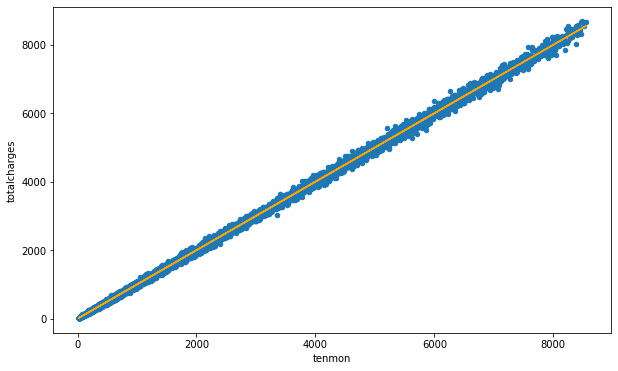

In [11]:
churn_wona = churn.assign(tenmon = churn.monthlycharges * churn.tenure).dropna()
churn_wona.plot("tenmon", "totalcharges", kind = "scatter", figsize = (10,6))
plt.plot(churn_wona.tenmon, lm.fittedvalues, color = 'orange')
plt.show()
del(churn_wona)

In [12]:
churn.fillna(0, inplace = True)
churn.to_csv('data/cleaned.csv', index = False)

# Code review

<img src="drawio/provider.png">

## Agent
- part of the domain piece of the architecture
- serves as a router for other modules

In [13]:
from abc import ABC,abstractmethod
from typing import List
from src.domain import Agent, Environment
from src.provider import DataProvider
from src.oracle import Oracle
from src.policy import Policy

In [14]:
# Agent is wrapper around DataProvider, Oracle and Policy
class Agent(ABC):
    #    
    def __init__(self, provider: DataProvider, oracle: Oracle, policy: Policy):
        super().__init__()
        self.provider = provider
        self.oracle = oracle
        self.policy = policy
    #
    def act(self, X: pd.DataFrame, time: int) -> int:
        pred = self.oracle.predict(X)
        return(self.policy.decide(pred, time))
    #
    def save_iter(self, context: pd.DataFrame, action:int, reward: int) -> None:
        self.provider.collect(context, action, reward)
    #
    def update(self) -> None:
        history = self.provider.provide()
        self.oracle.fit(history)
    #
    def replay(self) -> None:
        history = self.provider.provide(self.provider.size())
        self.oracle.fit(history)

## Learn
- part of the domain piece of the architecture
- defines the iterative process 

In [15]:
# Learn function handles the iterative learning of the Agent using the Environment
def learn(agent: Agent, env: Environment, iters: int, update_freq: int, replay_freq : int = None) -> None:
    replay = True
    if replay_freq is None:
        replay = False
    #
    for i in range(iters):
        if i > 0:
            if replay and (i % replay_freq == 0):
                agent.replay()
            elif i % update_freq == 0:
                agent.update()
        cx = env.get_context()
        act = agent.act(cx, i)
        rew = env.evaluate(act)
        agent.save_iter(cx, act, rew)
    return(agent)

## Oracle
- wrapper for set of (ML) models

In [16]:
# Oracle is a wrapper around set of models used to predict reward based on context
class Oracle(ABC):
    #
    def __init__(self, actions: List[int], min_reward: int):
        self.minrew = min_reward
        self.actions = actions
        self.oracles = {a : LinearRegression() for a in actions}
    #
    def fit(self, X: pd.DataFrame) -> None:
        for i in self.actions:
            self.__fit_oracle__(i, X.query("action == @i"))
    #
    def predict(self, X: pd.DataFrame) -> pd.Series:
        out = {
            i: self.__predict_oracle__(i, X)
            for i in self.actions
        }
        return(pd.Series(out))
    #
    @abstractmethod
    def __fit_oracle__(self, oracle: int, X: pd.DataFrame):
        pass
    #
    @abstractmethod
    def __predict_oracle__(self, oracle:int, X: pd.DataFrame):
        pass

## Policy

In [17]:
# Policy defines the tactic used to handle the exploration-exploitation tradeoff
class Policy(ABC):
    #
    @abstractmethod
    def decide(self, rewards: pd.Series, time: int) -> int:
        pass

## Provider

In [18]:
class DataProvider(ABC):
    #
    def __init__(self, batchsize: int):
        self.contexts = []
        self.actions = []
        self.rewards = []
        self.defsize = batchsize
    #
    def size(self) -> int:
        return(len(self.contexts))
    #
    def collect(self, context: pd.DataFrame, action: int, reward: float) -> None:
        self.contexts.append(context)
        self.actions.append(action)
        self.rewards.append(reward)
    #
    @abstractmethod
    def provide(self, size: int) -> pd.DataFrame:
        pass

## Implementations
Provider
- Batch
- Sample

Oracle
- LinReg
- OnReg
- RegTree
- Neural

Policy
- AdaGreed
- EpsGreed

## Reward specification

In [19]:
rewards = pd.DataFrame({
    "act":  [0,    0,    1,    1],
    "pred": [0,    1,    0,    1],
    "val":  [1, -1.5,   -2,  0.5]
}).pivot_table("val","pred","act")

rewards["mean"] = rewards.mean(axis = 1)

In [20]:
rewards

act,0,1,mean
pred,,,
0,1.0,-2.0,-0.5
1,-1.5,0.5,-0.5
